# Progetto d'esame per il corso Laboratorio di Software per le telecomunicazioni
_Andrea Argnani_
a.a. 2023/2024

## Traccia d'esame:
_In questo progetto, viene fornito il dataset housing.csv, in cui sono riportate le coordinate, numero di stanze, di camere da letto, abitanti e altre informazioni su delle abitazioni in California (per zona). L’obiettivo del progetto è quello di predire il valore medio dell’abitazione (median_house_value) con determinate caratteristiche._

## Importazione librerie:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
import numpy.random as rnd

In [39]:
RS = 24
rnd.seed(RS)

## Importazione dataset

In [40]:
df = pd.read_csv('housing.csv')
df.head(12)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


## data preprocessing

In [41]:
for column in df.columns:
    n_missing = df[column].isnull().sum()
    print(f"{column} -> {n_missing} missing values")

longitude -> 0 missing values
latitude -> 0 missing values
housing_median_age -> 0 missing values
total_rooms -> 0 missing values
total_bedrooms -> 207 missing values
population -> 0 missing values
households -> 0 missing values
median_income -> 0 missing values
median_house_value -> 0 missing values
ocean_proximity -> 0 missing values


L' unica colonna con dati mancanti è _total_bedrooms_. Possiamo ipotizzare che il numero di camere da letto sia proporzionale al numero di stanze, quindi possiamo calcolare il rapporto tra camere da letto e stanze e moltiplicarlo per il numero di stanze per ottenere il numero di camere da letto dove il dato manca.
Verifichiamo la nostra ipotesi calcolando la correlazione tra le due variabili:

Correlazione: 0.9303795046865079


<Axes: xlabel='total_rooms', ylabel='total_bedrooms'>

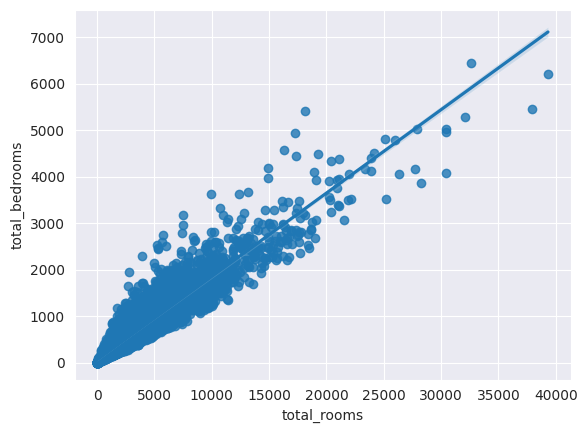

In [42]:
print(f"Correlazione: {df['total_bedrooms'].corr(df['total_rooms'])}")
sns.regplot(x='total_rooms', y='total_bedrooms', data=df)

La correlazione è molto alta (0.93), procediamo a sostituire i valori mancanti con il valore calcolato:

In [43]:
df_p = df.dropna(subset=['total_bedrooms'])
BoR = df_p['total_bedrooms'] / df_p['total_rooms']
df['total_bedrooms'] = df['total_bedrooms'].fillna(df['total_rooms'] * BoR.mean())

### Ricerca di misspelling nelle variabili non numeriche:

In [44]:
print(df['ocean_proximity'].unique())

['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']


Non ci sono misspelling nelle variabili non numeriche

### Ricerca di outlier

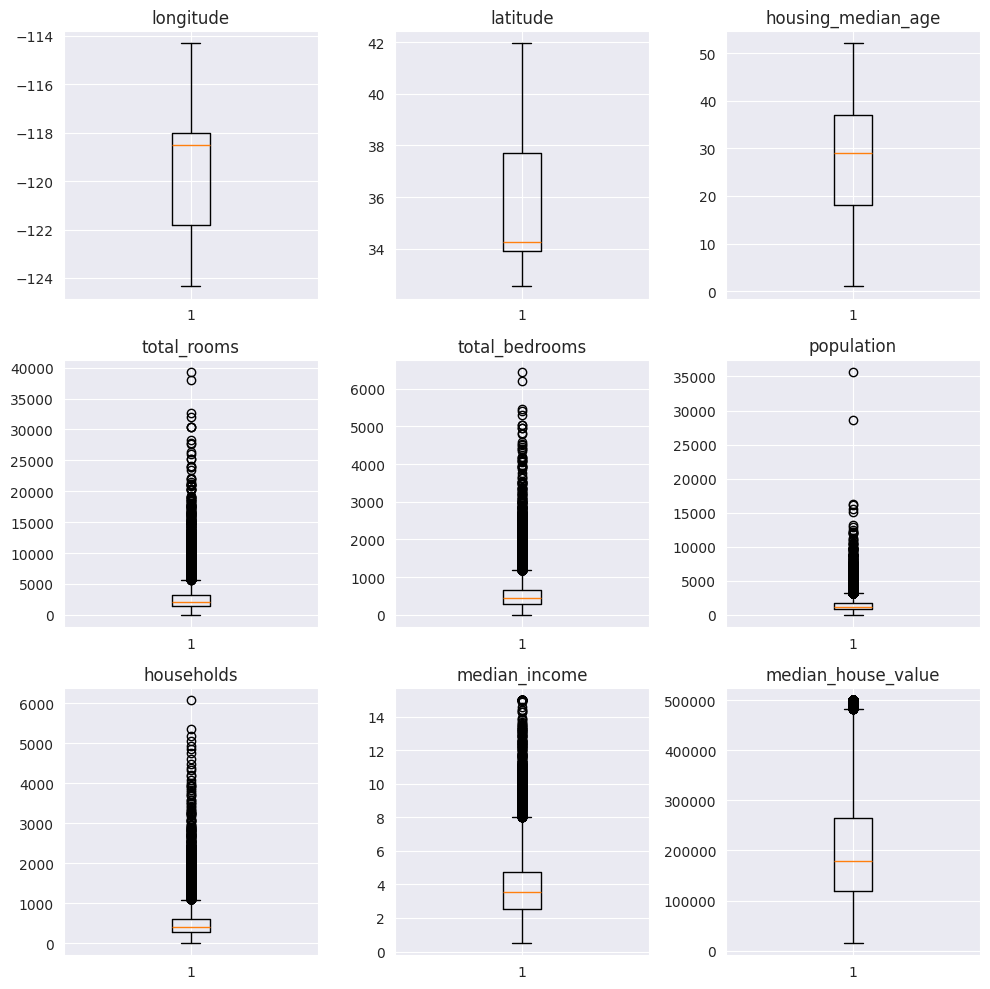

In [45]:
df_noOp = df.drop(columns=['ocean_proximity'])
fig, axis = plt.subplots(3, 3, figsize=(10, 10))
for i, column in enumerate(df_noOp.columns):
    axis[i//3, i%3].boxplot(df_noOp[column])
    axis[i//3, i%3].set_title(column)
plt.tight_layout()
plt.show()

La presenza di valori fuori dai range è dovuta alla distribuzione dei dati.

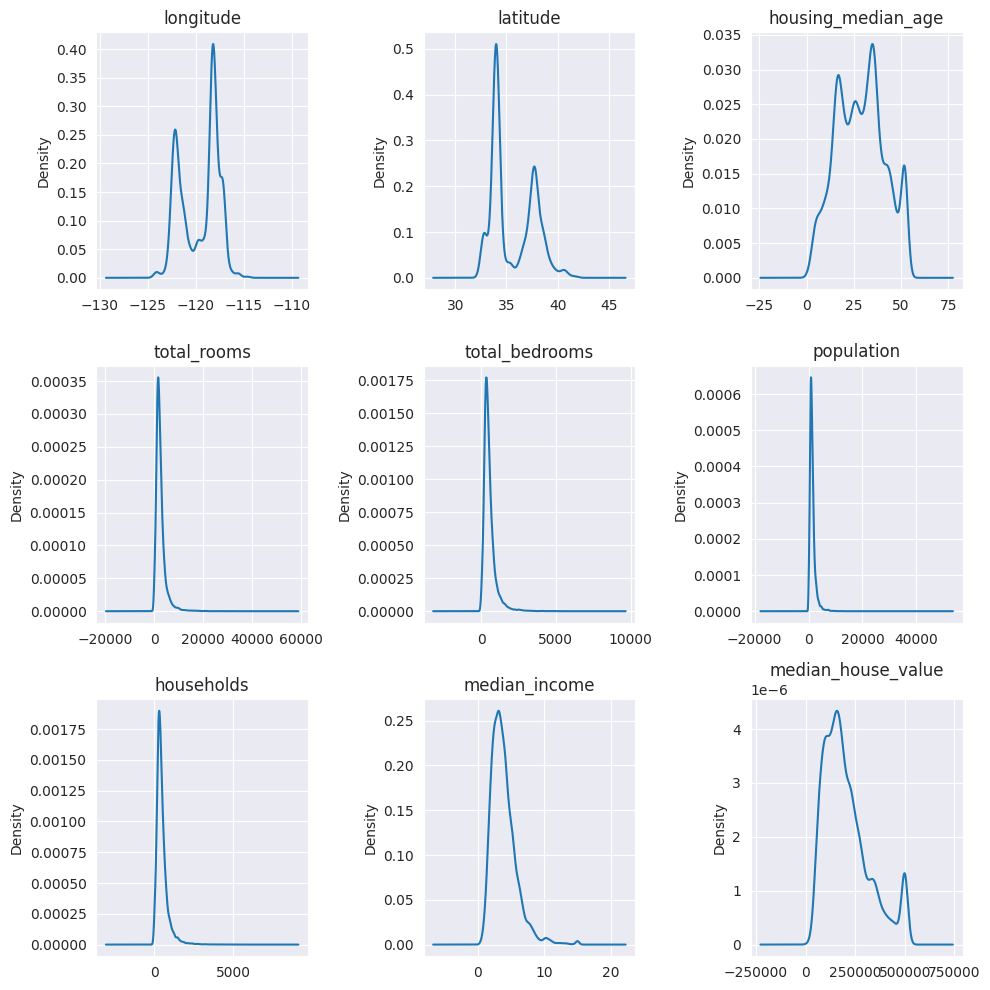

In [46]:
fig, axis = plt.subplots(3, 3, figsize=(10, 10))
for i, column in enumerate(df_noOp.columns):
    ax = axis[i//3, i%3]
    df_noOp[column].plot(kind='kde', ax=ax)
    ax.set_title(column)
plt.tight_layout()
plt.show()

## Data format
Si convertono i valori di _ocean_proximity_ in valori numerici:

In [47]:
print(df.dtypes)
df = pd.get_dummies(data=df, columns=['ocean_proximity'], drop_first=False)
print(df.dtypes)
df.head(12)

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object
longitude                     float64
latitude                      float64
housing_median_age            float64
total_rooms                   float64
total_bedrooms                float64
population                    float64
households                    float64
median_income                 float64
median_house_value            float64
ocean_proximity_<1H OCEAN        bool
ocean_proximity_INLAND           bool
ocean_proximity_ISLAND           bool
ocean_proximity_NEAR BAY         bool
ocean_proximity_NEAR OCEAN       bool
dtype: object


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,False,False,False,True,False
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,False,False,False,True,False
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,False,False,False,True,False
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,False,False,False,True,False
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,False,False,False,True,False
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,False,False,False,True,False
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,False,False,False,True,False
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,False,False,False,True,False
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,False,False,False,True,False
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,False,False,False,True,False


# Regressione lineare semplice
Si sceglie la variabile con la più alta correlazione:

In [48]:
for i, col in enumerate(df.columns):
    if col != 'median_house_value':
        print(f"Correlazione tra prezzo e {col}: {df['median_house_value'].corr(df[col])}")

Correlazione tra prezzo e longitude: -0.04596661511797843
Correlazione tra prezzo e latitude: -0.14416027687465927
Correlazione tra prezzo e housing_median_age: 0.10562341249320994
Correlazione tra prezzo e total_rooms: 0.13415311380656306
Correlazione tra prezzo e total_bedrooms: 0.051376529738816214
Correlazione tra prezzo e population: -0.02464967888889488
Correlazione tra prezzo e households: 0.06584265057005646
Correlazione tra prezzo e median_income: 0.6880752079585477
Correlazione tra prezzo e ocean_proximity_<1H OCEAN: 0.25661683623001535
Correlazione tra prezzo e ocean_proximity_INLAND: -0.48485933464866887
Correlazione tra prezzo e ocean_proximity_ISLAND: 0.023416076436869285
Correlazione tra prezzo e ocean_proximity_NEAR BAY: 0.16028448367166812
Correlazione tra prezzo e ocean_proximity_NEAR OCEAN: 0.14186216979619454


La variabile con la più alta correlazione è _median_income_. Questo il suo grafico di correlazione:

<Axes: xlabel='median_income', ylabel='median_house_value'>

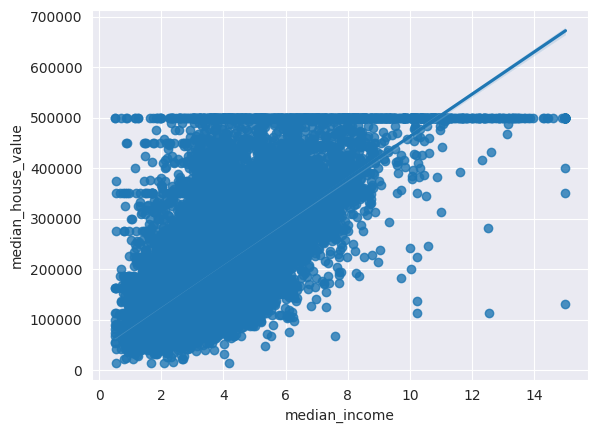

In [49]:
sns.regplot(x='median_income', y='median_house_value', data=df)

### Train test split

In [50]:
df_reg = df[['median_income', 'median_house_value']]
X = df_reg.drop(columns=['median_house_value'])
Y = df_reg['median_house_value']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=RS)

### Calcolo regressione lineare:

In [57]:
regressor = LinearRegression()
regressor.fit(X_train, Y_train)

y_hat = regressor.predict(X_test)

### Prestazioni del modello

In [58]:
def prestazioni(y_hat_p, Y_test_p, n_feature):
    mse = np.mean((y_hat_p - Y_test_p)**2)
    mae = np.mean(np.abs(y_hat_p - Y_test_p))
    print(f"MSE: {mse}")
    print(f"Root MSE: {np.sqrt(mse)}")
    print(f"MAE: {mae}")
    print(f"R2 score {r2_score(Y_test_p, y_hat_p)}")
    print(f"Adj. R2 score {adj_r2_score(Y_test_p, y_hat_p, n_feature)}")
    
def adj_r2_score(y_true, y_pred, n_features):
    return 1 - (1 - r2_score(y_true, y_pred)) * (len(y_true) - 1) / (len(y_true) - n_features - 1)

In [59]:
prestazioni(y_hat, Y_test, 1)

MSE: 6744576854.437529
Root MSE: 82125.37278111758
MAE: 61634.123079362456
R2 score 0.49099848976352456
Adj. R2 score 0.4908751253645337


## Con k-fold cross validation

In [69]:
results = []
n_folds = [5, 10, 50,  100, 200, 500, 1000, 2000]
print("n_fold:\t\t\tR2 score:")
for n_fold in n_folds:
    kf = KFold(n_splits=n_fold, random_state=42, shuffle=True)
    regressor = LinearRegression()
    y_hat = cross_val_predict(regressor, X, Y, cv=kf)
    results.append([n_fold, adj_r2_score(Y, y_hat, 1)])
    print(f"{n_fold}\t\t{r2_score(Y, y_hat)}\t\t{adj_r2_score(Y, y_hat, 1)}")

results = np.array(results)

n_fold:			R2 score:
5		0.473386398946553		0.47336088224914763
10		0.47333428543827527		0.4733087662157458
50		0.4733243847698352		0.4732988650675758
100		0.4733228450184337		0.47329732524156665
200		0.47334016710496196		0.47331464816742463
500		0.47333063933567365		0.47330511993647484
1000		0.4733247816981955		0.4732992620151689
2000		0.47332318080132585		0.4732976610407289


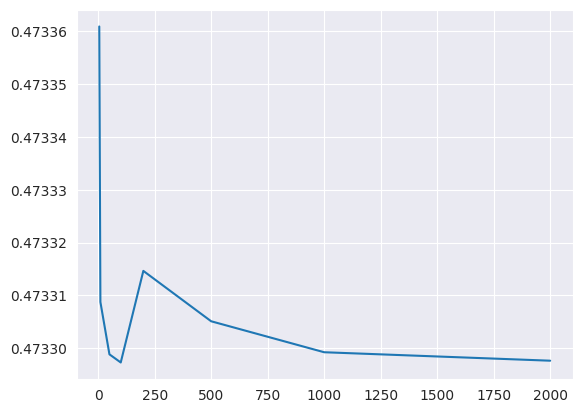

In [70]:
plt.plot(results[:, 0], results[:, 1])
plt.show()

# Regressione lineare multipla

## Senza feature selection:

In [79]:
X = df.drop(columns=['median_house_value'])
Y = df['median_house_value']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=RS)

regressor = LinearRegression()
regressor.fit(X_train, Y_train)
y_hat = regressor.predict(X_test)
prestazioni(y_hat, Y_test, len(X.columns))

MSE: 4530943903.884664
Root MSE: 67312.2864259168
MAE: 49424.954481699584
R2 score 0.6580575268622426
Adj. R2 score 0.6569770085951568


## Con k-fold cross validation

In [82]:
n_fold = 5
kf = KFold(n_splits=n_fold, random_state=RS, shuffle=True)
regressor = LinearRegression()
y_hat = cross_val_predict(regressor, X, Y, cv=kf)
prestazioni(y_hat, Y, len(X.columns))

MSE: 4726502150.155624
Root MSE: 68749.56109063988
MAE: 49805.84544185541
R2 score 0.6450376564921927
Adj. R2 score 0.6448139334986117


## Con k-fold cross validation e feature selection
### Selezione delle feature:
Si prendono le feature con correlazione maggiore rispetto a _median_house_value_

In [87]:
df_reg = df[['median_income', 'ocean_proximity_<1H OCEAN','ocean_proximity_INLAND', 'median_house_value']]
X = df_reg.drop(columns=['median_house_value'])
Y = df_reg['median_house_value']

n_fold = 5
kf = KFold(n_splits=n_fold, random_state=RS, shuffle=True)
regressor = LinearRegression()
y_hat = cross_val_predict(regressor, X, Y, cv=kf)
prestazioni(y_hat, Y, len(X.columns))

MSE: 5496899756.669274
Root MSE: 74141.08008836447
MAE: 53740.305577836385
R2 score 0.5871804650315083
Adj. R2 score 0.587120450561412


In [85]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
y_hat = regressor.predict(X_test)
prestazioni(y_hat, Y_test, len(X.columns))


MSE: 5522197682.686186
Root MSE: 74311.49091954881
MAE: 53862.23025361438
R2 score 0.5889081505241873
Adj. R2 score 0.5886091021370807


# Rimozione outlier

In [ ]:
df_reg = df[['median_income', 'ocean_proximity_<1H OCEAN','ocean_proximity_INLAND', 'median_house_value']]
X = df_reg.drop(columns=['median_house_value'])
Y = df_reg['median_house_value']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

df_train = pd.concat([X_train, Y_train], axis=1)
df_train = df_train[df_train['median_house_value'] < 500000]
X_train = df_train.drop(columns=['median_house_value'])
Y_train = df_train['median_house_value']

regressor = LinearRegression()
regressor.fit(X_train, Y_train)
y_hat = regressor.predict(X_test)
prestazioni(y_hat, Y_test)

# Recap dei risultati 
(con RS=24)

| Modello                                 | Validation          | R2 score    | Adj. R2 score |
|-----------------------------------------|---------------------|-------------|---------------|
| Reg. lin. semplice                      | Holdout             | 0.49099     | 0.49087       |
| Reg. lin. semplice                      | K-fold (n_fold=5)   | 0.47338     | 0.47336       |
| Reg. lin. multipla con tutte le feature | Holdout             | 0.65805     | 0.65697       |
| Reg. lin. multipla con tutte le feature | K-fold (n_fold=5)   | 0.64503     | 0.64481       |
| Reg. lin. multipla con feature selez.   | Holdout             | 0.58890     | 0.58860       |
| Reg. lin. multipla con feature selez.   | K-fold (n_fold=600) | 0.58718     | 0.58712       |


